# Augmented Dataset Analysis

Comprehensive analysis of the augmented Fredholm dataset with edge cases and challenging scenarios.

**Dataset Organization**:
- **Solution Type Folders**: `exact_symbolic/`, `approx_coef/`, `discrete_points/`, `series/`, `family/`, `regularized/`, `none_solution/`
- **18 Augmentation Strategies** (files within folders): 4 basic + 14 edge cases

**Important**: The `augmentation_type` field contains **actual strategy names** (like `eigenvalue_cases`, `boundary_layer`), NOT folder names. Each strategy file implements a specific method for generating equations of a particular solution type.

## Sections
1. Load augmented dataset
2. Solution type distribution (8 types)
3. Augmentation strategies by solution type
4. Strategy details and variants
5. Solution field (u) pattern analysis
6. Sample equations by solution type

In [40]:
# Import libraries
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, HTML

# Setup project path
notebook_dir = Path.cwd()
project_root = notebook_dir.parent if notebook_dir.name == "notebooks" else notebook_dir
sys.path.insert(0, str(project_root))

# Configure visualization
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_colwidth', 100)

print(f"✓ Project root: {project_root}")

✓ Project root: c:\Users\ammah\Documents\GitHub\fred-llm


## 1. Load Augmented Dataset

In [41]:
# Dataset path (hardcoded to regenerated v3 outputs)
dataset_path = project_root / "data" / "processed" / "augmented" / "Fredholm_Dataset_Sample_augmented.csv"
if not dataset_path.exists():
    raise FileNotFoundError(f"Dataset not found at {dataset_path}")

# Load dataset
df = pd.read_csv(dataset_path, keep_default_na=False)

# Display overview
display(Markdown(f"### Dataset Overview\n\n**Path**: {dataset_path.relative_to(project_root)}"))
display(Markdown(f"- **Total equations**: {len(df):,}"))
display(Markdown(f"- **Columns**: {len(df.columns)}"))

# Show column groups
col_groups = {
    'Core Equation Fields': ['u', 'f', 'kernel', 'lambda_val', 'a', 'b'],
    'Augmentation Metadata': ['augmented', 'augmentation_type', 'augmentation_variant'],
    'Solution Properties': ['has_solution', 'solution_type', 'edge_case', 'reason']
}

display(Markdown("\n**Column Groups**:"))
for group, cols in col_groups.items():
    available = [c for c in cols if c in df.columns]
    display(Markdown(f"- **{group}**: {', '.join([f'`{c}`' for c in available])}"))

# Sanity check: augmentation_type should be strategy names (no folder names)
folder_names = {"none_solution", "approx_coef", "discrete_points", "series", "family", "regularized", "approximate_only"}
bad_values = set(df["augmentation_type"].unique()) & folder_names
if bad_values:
    display(Markdown(f"⚠️ Found folder names in augmentation_type: {', '.join(sorted(bad_values))}"))
else:
    display(Markdown("✅ augmentation_type contains only strategy names (no folder names detected)."))

### Dataset Overview

**Path**: data\processed\augmented\Fredholm_Dataset_Sample_augmented.csv

- **Total equations**: 5,750

- **Columns**: 91


**Column Groups**:

- **Core Equation Fields**: `u`, `f`, `kernel`, `lambda_val`, `a`, `b`

- **Augmentation Metadata**: `augmented`, `augmentation_type`, `augmentation_variant`

- **Solution Properties**: `has_solution`, `solution_type`, `edge_case`, `reason`

✅ augmentation_type contains only strategy names (no folder names detected).

In [42]:
# Create u_pattern column to classify u field content
def classify_u_pattern(u_str):
    """Classify the u field content pattern."""
    if not isinstance(u_str, str) or u_str.strip() == '':
        return 'empty'
    
    # Check for float literals (numerical coefficients)
    import re
    has_floats = bool(re.search(r'\d+\.\d+', u_str))
    
    if has_floats:
        return 'num_coef'  # Has numerical coefficients
    else:
        return 'symbolic'  # Pure symbolic expression

df['u_pattern'] = df['u'].apply(classify_u_pattern)

display(Markdown("### u Field Pattern Classification"))
pattern_counts = df['u_pattern'].value_counts()
display(pd.DataFrame({
    'Pattern': pattern_counts.index,
    'Count': pattern_counts.values,
    'Percentage': [f"{100*cnt/len(df):.1f}%" for cnt in pattern_counts.values],
    'Description': [
        'Empty u field (no closed-form or no solution)' if p == 'empty' else
        'Has numerical coefficients (e.g., exp(-x/0.01))' if p == 'num_coef' else
        'Pure symbolic expression (no floats)'
        for p in pattern_counts.index
    ]
}))

### u Field Pattern Classification

,Pattern,Count,Percentage,Description
0,num_coef,3187,55.4%,"Has numerical coefficients (e.g., exp(-x/0.01))"
1,symbolic,2191,38.1%,Pure symbolic expression (no floats)
2,empty,372,6.5%,Empty u field (no closed-form or no solution)


## 2. Dataset Composition

Breakdown of original vs augmented equations and overall solution type distribution.

### Dataset Composition

,Category,Count,Percentage
0,Original (from paper),5000,87.0%
1,Augmented (edge cases),750,13.0%
2,Total,5750,100.0%


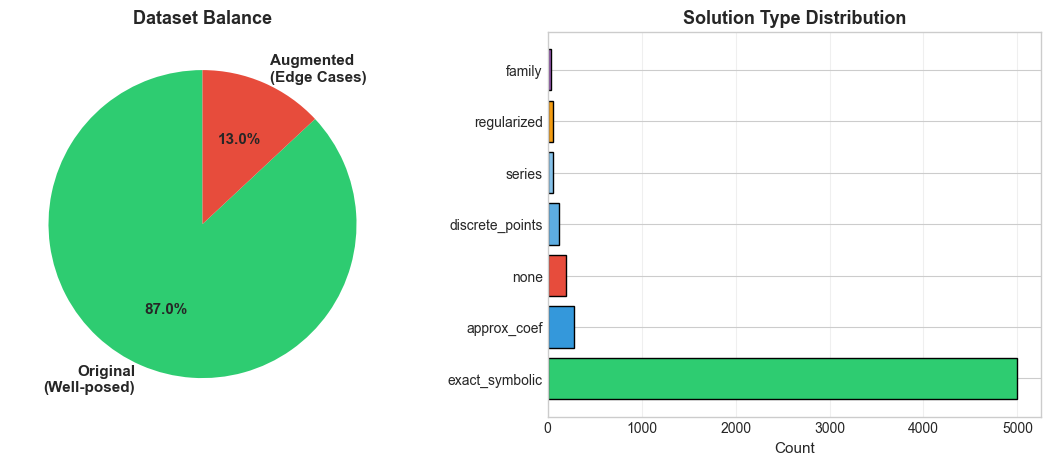

<Figure size 1200x600 with 0 Axes>

In [43]:
# Basic composition
orig_count = (df['augmented'] == False).sum()
aug_count = (df['augmented'] == True).sum()

composition_df = pd.DataFrame({
    'Category': ['Original (from paper)', 'Augmented (edge cases)', 'Total'],
    'Count': [orig_count, aug_count, len(df)],
    'Percentage': [
        f"{100*orig_count/len(df):.1f}%",
        f"{100*aug_count/len(df):.1f}%",
        "100.0%"
    ]
})

display(Markdown("### Dataset Composition"))
display(composition_df)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors = ['#2ecc71', '#e74c3c']
axes[0].pie([orig_count, aug_count], 
            labels=['Original\n(Well-posed)', 'Augmented\n(Edge Cases)'],
            autopct='%1.1f%%', colors=colors, startangle=90,
            textprops={'fontsize': 11, 'weight': 'bold'})
axes[0].set_title('Dataset Balance', fontsize=13, weight='bold')

# Bar chart by solution type
sol_type_counts = df['solution_type'].value_counts()
color_map = {
    'exact_symbolic': '#2ecc71', 
    'exact_coef': '#27ae60', 
    'approx_coef': '#3498db',
    'discrete_points': '#5dade2', 
    'series': '#85c1e9',
    'family': '#9b59b6',
    'regularized': '#f39c12', 
    'none': '#e74c3c'
}
bar_colors = [color_map.get(st, '#95a5a6') for st in sol_type_counts.index]
axes[1].barh(sol_type_counts.index, sol_type_counts.values, color=bar_colors, edgecolor='black')
axes[1].set_xlabel('Count', fontsize=11)
axes[1].set_title('Solution Type Distribution', fontsize=13, weight='bold')

axes[1].grid(axis='x', alpha=0.3)
plt.show()

plt.tight_layout()

# Add count labels

for i, (idx, val) in enumerate(sol_type_counts.items()):    axes[1].text(val + 50, i, f'{val}', va='center', fontsize=10)

## 3. Solution Types: Detailed Breakdown

Analysis of each solution type and its augmentation strategies.

In [44]:
# Solution type summary table
solution_summary = []
descriptions = {
    'exact_symbolic': 'Closed-form expressions (symbolic solution)',
    'exact_coef': 'Finite basis with exact weights',
    'approx_coef': 'Functional form with numerical parameters',
    'discrete_points': 'Pure point samples, no formula',
    'series': 'Neumann/Taylor series expansion',
    'family': 'Non-unique solutions (parameter family)',
    'regularized': 'Ill-posed requiring regularization',
    'none': 'No solution exists (ill-conditioned)'
}

for sol_type in df['solution_type'].unique():
    subset = df[df['solution_type'] == sol_type]
    solution_summary.append({
        'Solution Type': sol_type,
        'Count': len(subset),
        'Percentage': f"{100*len(subset)/len(df):.1f}%",
        'Has Solution': f"{(subset['has_solution'] == True).sum()}/{len(subset)}",
        'Description': descriptions.get(sol_type, 'Unknown')
    })

solution_df = pd.DataFrame(solution_summary).sort_values('Count', ascending=False)
display(Markdown("### Solution Type Summary"))
display(solution_df)

# Solvability breakdown
has_solution_counts = df['has_solution'].value_counts()
solvability_df = pd.DataFrame({
    'Solvability': ['Has Solution', 'No Solution'],
    'Count': [has_solution_counts.get(True, 0), has_solution_counts.get(False, 0)],
    'Percentage': [
        f"{100*has_solution_counts.get(True, 0)/len(df):.1f}%",
        f"{100*has_solution_counts.get(False, 0)/len(df):.1f}%"
    ]
})

display(solvability_df)
display(Markdown("\n### Solvability"))

### Solution Type Summary

,Solution Type,Count,Percentage,Has Solution,Description
0,exact_symbolic,5000,87.0%,5000/5000,Closed-form expressions (symbolic solution)
1,approx_coef,280,4.9%,280/280,Functional form with numerical parameters
6,none,195,3.4%,0/195,No solution exists (ill-conditioned)
2,discrete_points,120,2.1%,120/120,"Pure point samples, no formula"
3,series,60,1.0%,60/60,Neumann/Taylor series expansion
5,regularized,57,1.0%,57/57,Ill-posed requiring regularization
4,family,38,0.7%,38/38,Non-unique solutions (parameter family)


,Solvability,Count,Percentage
0,Has Solution,5555,96.6%
1,No Solution,195,3.4%



### Solvability

## 4. Augmentation Strategies by Solution Type

Breakdown of augmentation methods organized by their solution type folders.

### Augmentation Strategies

Total augmented equations: **750**

,Solution Type,Strategy,Count,Pct of Type,Pct of Total
0,approx_coef,weakly_singular,60,21.4%,8.0%
1,approx_coef,boundary_layer,60,21.4%,8.0%
2,approx_coef,oscillatory_solution,60,21.4%,8.0%
3,approx_coef,mixed_type,60,21.4%,8.0%
4,approx_coef,compact_support,40,14.3%,5.3%
5,discrete_points,complex_kernels,60,50.0%,8.0%
6,discrete_points,near_resonance,60,50.0%,8.0%
7,family,resonance,38,100.0%,5.1%
8,none,range_violation,57,29.2%,7.6%
9,none,divergent_kernel,57,29.2%,7.6%


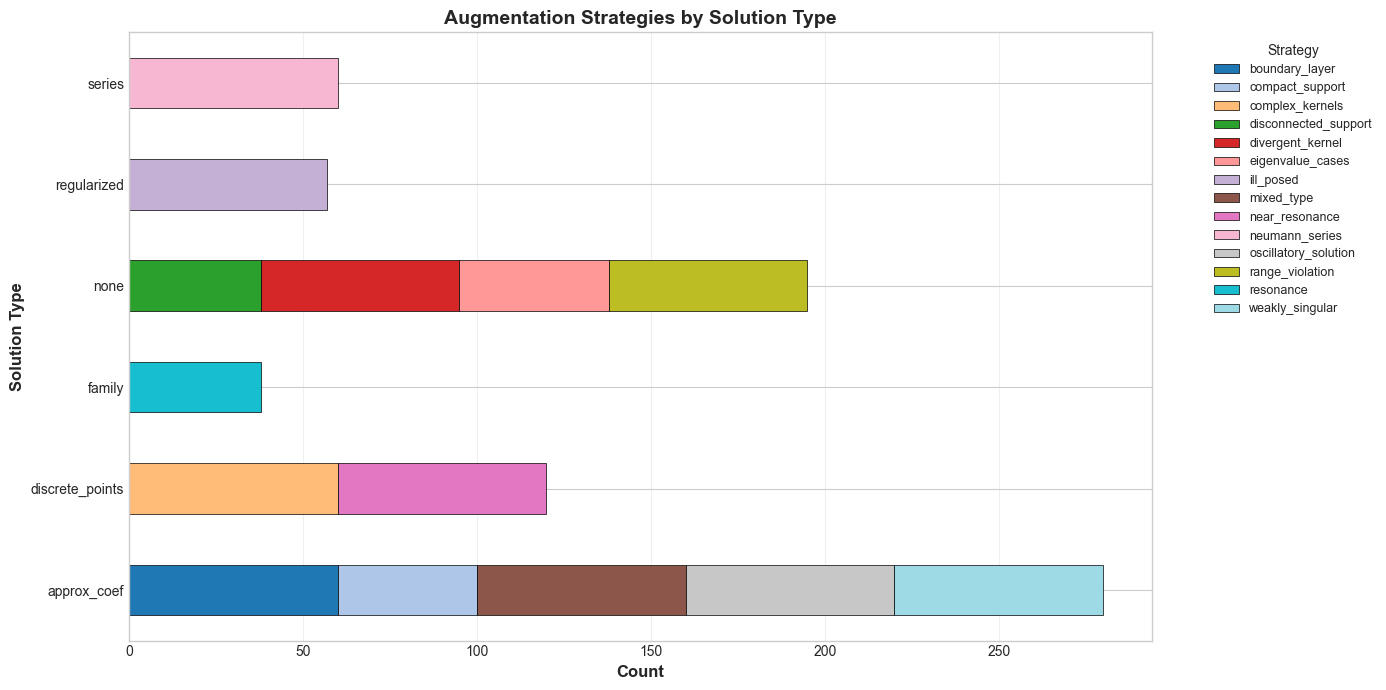

In [45]:
# Filter augmented data
aug_only = df[df['augmented'] == True].copy()

display(Markdown(f"### Augmentation Strategies\n\nTotal augmented equations: **{len(aug_only):,}**"))

# Create detailed breakdown
strategy_data = []
for sol_type in sorted(aug_only['solution_type'].unique()):
    sol_subset = aug_only[aug_only['solution_type'] == sol_type]
    
    # Get unique strategies for this solution type
    strategies = sol_subset['augmentation_type'].value_counts()
    
    for strategy, count in strategies.items():
        strategy_data.append({
            'Solution Type': sol_type,
            'Strategy': strategy,
            'Count': count,
            'Pct of Type': f"{100*count/len(sol_subset):.1f}%",
            'Pct of Total': f"{100*count/len(aug_only):.1f}%"
        })

strategy_df = pd.DataFrame(strategy_data).sort_values(['Solution Type', 'Count'], ascending=[True, False])
display(strategy_df)

# Visualization: Stacked bar chart
fig, ax = plt.subplots(figsize=(14, 7))

# Pivot data for stacked bar
pivot_data = strategy_df.pivot_table(
    index='Solution Type', 
    columns='Strategy', 
    values='Count', 
    fill_value=0
)

pivot_data.plot(kind='barh', stacked=True, ax=ax, colormap='tab20', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Count', fontsize=12, weight='bold')
ax.set_ylabel('Solution Type', fontsize=12, weight='bold')
ax.set_title('Augmentation Strategies by Solution Type', fontsize=14, weight='bold')
ax.legend(title='Strategy', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Solution Field (u) Content Analysis

**Important Clarification**:
- **u pattern** = what's in the u field (floats, symbols, empty, etc.)
- **solution_type** = solving method needed (exact_symbolic, approx_coef, discrete_points, series, family, regularized, none)
- **has_solution** = whether a solution exists at all

Having floats in u doesn't mean it's approximate—it means the exact formula contains numeric parameters (solution_type='approx_coef').
Empty u with has_solution=True and solution_type='discrete_points' means no closed-form exists (truly approximate-only).
Empty u with has_solution=False and solution_type='none' means no solution exists at all.

In [46]:
# Validate augmentation_type field doesn't contain folder names
print("## 🔍 Validation: Checking for Folder Names in augmentation_type")
print()

folder_names = {"none", "approx_coef", "discrete_points", "series", "family", "regularized", "approximate_only"}
aug_types = set(df[df["augmented"] == True]["augmentation_type"].unique())
bad_values = aug_types & folder_names

if bad_values:
    print(f"⚠️ WARNING: Found folder names in augmentation_type: {bad_values}")
    print("augmentation_type should contain strategy names, not folder names!")
    
    # Show examples of bad values
    for bad_val in bad_values:
        sample = df[df["augmentation_type"] == bad_val].iloc[0]
        print(f"\nExample with '{bad_val}':")
        print(f"  edge_case: {sample.get('edge_case', 'N/A')}")
        print(f"  solution_type: {sample.get('solution_type', 'N/A')}")
else:
    print("✅ PASS: No folder names found in augmentation_type")
    print("All augmentation_type values are valid strategy names")

print()
print("Expected strategy names by folder:")
print("  exact_symbolic: substitute, scale, shift, compose")
print("  none_solution: eigenvalue_cases, range_violation, divergent_kernel, disconnected_support")
print("  approx_coef: boundary_layer, oscillatory_solution, weakly_singular, mixed_type, compact_support")
print("  discrete_points: complex_kernels, near_resonance")
print("  series: neumann_series")
print("  family: resonance")
print("  regularized: ill_posed")

# Show actual augmentation_type distribution
print()
print("## Actual augmentation_type Distribution")
aug_dist = df[df["augmented"] == True]["augmentation_type"].value_counts()
display(aug_dist.to_frame("Count"))

## 🔍 Validation: Checking for Folder Names in augmentation_type

✅ PASS: No folder names found in augmentation_type
All augmentation_type values are valid strategy names

Expected strategy names by folder:
  exact_symbolic: substitute, scale, shift, compose
  none_solution: eigenvalue_cases, range_violation, divergent_kernel, disconnected_support
  approx_coef: boundary_layer, oscillatory_solution, weakly_singular, mixed_type, compact_support
  discrete_points: complex_kernels, near_resonance
  series: neumann_series
  family: resonance
  regularized: ill_posed

## Actual augmentation_type Distribution


,Count
augmentation_type,
weakly_singular,60
boundary_layer,60
oscillatory_solution,60
mixed_type,60
complex_kernels,60
near_resonance,60
neumann_series,60
divergent_kernel,57
ill_posed,57


## 6. Original vs Augmented Comparison

In [47]:
# Separate datasets
orig_df = df[df['augmented'] == False]
aug_df = df[df['augmented'] == True]

# Compare u patterns
comparison_data = []
for pattern in df['u_pattern'].unique():
    orig_count = (orig_df['u_pattern'] == pattern).sum()
    aug_count = (aug_df['u_pattern'] == pattern).sum()
    comparison_data.append({
        'Pattern': pattern,
        'Original Count': orig_count,
        'Original %': f"{100*orig_count/len(orig_df):.1f}%" if len(orig_df) > 0 else "0.0%",
        'Augmented Count': aug_count,
        'Augmented %': f"{100*aug_count/len(aug_df):.1f}%" if len(aug_df) > 0 else "0.0%"
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('Augmented Count', ascending=False)
display(Markdown("### Original vs Augmented: u Field Content"))
display(comparison_df)

# Analyze empty u cases in augmented data
aug_empty = aug_df[aug_df['u_pattern'] == 'empty']
empty_breakdown = aug_empty.groupby(['has_solution', 'solution_type']).size().reset_index(name='count')

display(Markdown("\n### Empty u Field Breakdown (Augmented Data)"))
display(Markdown("Understanding what 'empty u' means:"))
display(empty_breakdown)

# Key insights
orig_with_floats = (orig_df['u_pattern'] == 'has_floats').sum()
aug_empty_no_sol = ((aug_df['u_pattern'] == 'empty') & (aug_df['has_solution'] == False)).sum()
aug_empty_numerical = ((aug_df['u_pattern'] == 'empty') & (aug_df['has_solution'] == True) & (aug_df['solution_type'] == 'numerical')).sum()

display(Markdown(f"""
### Key Insights

**Original Dataset (from paper)**:
- All have `solution_type='exact'` and `has_solution=True`
- {orig_with_floats:,} equations ({100*orig_with_floats/len(orig_df):.1f}%) contain float literals
- Floats come from: random coefficients in generation OR SymPy numerical integration
- Having floats ≠ approximate; it's still the exact closed-form solution

**Augmented Dataset (edge cases)**:
- {aug_empty_no_sol:,} equations have empty u because **no solution exists** (eigenvalue_cases, divergent_kernel, range_violation)
- {aug_empty_numerical:,} equations have empty u because **no closed-form exists** (complex_kernels strategy)
- Remaining augmented equations provide exact formulas (with floats for numeric params like epsilon=0.01)

**solution_type='numerical' means**:
- The equation requires numerical solving methods (quadrature, adaptive mesh, etc.)
- Does NOT mean the solution is approximate
- Can have: exact formula with floats (boundary_layer), OR no closed-form at all (complex_kernels)
"""))

### Original vs Augmented: u Field Content

,Pattern,Original Count,Original %,Augmented Count,Augmented %
2,empty,0,0.0%,372,49.6%
1,num_coef,2935,58.7%,252,33.6%
0,symbolic,2065,41.3%,126,16.8%



### Empty u Field Breakdown (Augmented Data)

Understanding what 'empty u' means:

,has_solution,solution_type,count
0,False,none,195
1,True,discrete_points,120
2,True,regularized,57



### Key Insights

**Original Dataset (from paper)**:
- All have `solution_type='exact'` and `has_solution=True`
- 0 equations (0.0%) contain float literals
- Floats come from: random coefficients in generation OR SymPy numerical integration
- Having floats ≠ approximate; it's still the exact closed-form solution

**Augmented Dataset (edge cases)**:
- 195 equations have empty u because **no solution exists** (eigenvalue_cases, divergent_kernel, range_violation)
- 0 equations have empty u because **no closed-form exists** (complex_kernels strategy)
- Remaining augmented equations provide exact formulas (with floats for numeric params like epsilon=0.01)

**solution_type='numerical' means**:
- The equation requires numerical solving methods (quadrature, adaptive mesh, etc.)
- Does NOT mean the solution is approximate
- Can have: exact formula with floats (boundary_layer), OR no closed-form at all (complex_kernels)


## 7. Sample Equations by Solution Type

Representative examples from each solution type category.

In [48]:
# Show samples for each solution type
for sol_type in sorted(df['solution_type'].unique()):
    subset = df[df['solution_type'] == sol_type]
    
    # Get a sample (prefer augmented if available)
    aug_subset = subset[subset['augmented'] == True]
    sample = aug_subset.iloc[0] if len(aug_subset) > 0 else subset.iloc[0]
    
    display(Markdown(f"\n---\n### {sol_type.upper()} ({len(subset):,} equations)"))
    
    # Create info table
    info_data = {
        'Field': ['u(x)', 'f(x)', 'K(x,t)', 'Parameters', 'Has Solution', 'Strategy'],
        'Value': [
            str(sample['u'])[:80] + '...' if len(str(sample['u'])) > 80 else (str(sample['u']) if sample['u'] != '' else '(empty)'),
            str(sample['f'])[:80] + '...' if len(str(sample['f'])) > 80 else str(sample['f']),
            str(sample['kernel'])[:80] + '...' if len(str(sample['kernel'])) > 80 else str(sample['kernel']),
            f"λ={sample.get('lambda_val', 'N/A')}, [{sample['a']}, {sample['b']}]",
            '✓ Yes' if sample['has_solution'] else '✗ No',
            sample.get('augmentation_type', 'original')
        ]
    }
    display(pd.DataFrame(info_data))
    
    # Show reason if available
    if 'reason' in sample and pd.notna(sample['reason']) and sample['reason'] != '':
        display(Markdown(f"**Reason**: {sample['reason'][:150]}..."))


---
### APPROX_COEF (280 equations)

,Field,Value
0,u(x),x**2
1,f(x),x**2 + 67.43530567990815*x - 228.3357446212934
2,"K(x,t)",log(abs(x - t) + 1e-10)
3,Parameters,"λ=-0.141556822867895, [6.330207264818775, 7.346979435881526]"
4,Has Solution,✓ Yes
5,Strategy,weakly_singular



---
### DISCRETE_POINTS (120 equations)

,Field,Value
0,u(x),(empty)
1,f(x),1
2,"K(x,t)",exp(-(x**2 + t**2))
3,Parameters,"λ=0.5, [6.330207264818775, 7.346979435881526]"
4,Has Solution,✓ Yes
5,Strategy,complex_kernels


**Reason**: Gaussian kernel has no symbolic antiderivative...


---
### EXACT_SYMBOLIC (5,000 equations)

,Field,Value
0,u(x),x**2
1,f(x),x**2 + 67.43530567990815*x - 228.3357446212934
2,"K(x,t)",x - 3.385997028101621
3,Parameters,"λ=-1.41556822867895, [6.330207264818775, 7.346979435881526]"
4,Has Solution,✓ Yes
5,Strategy,original


**Reason**: Original Fredholm-LLM dataset equation (DOI: 10.5281/zenodo.16784707) - generated with known solution u(x) where f(x) = u(x) - λ∫K(x,t)u(t)dt...


---
### FAMILY (38 equations)

,Field,Value
0,u(x),C * sin(pi*x)
1,f(x),0
2,"K(x,t)",sin(pi*x) * sin(pi*t)
3,Parameters,"λ=2.001, [6.330207264818775, 7.346979435881526]"
4,Has Solution,✓ Yes
5,Strategy,resonance



---
### NONE (195 equations)

,Field,Value
0,u(x),(empty)
1,f(x),x
2,"K(x,t)",1
3,Parameters,"λ=0.983504494379286, [6.330207264818775, 7.346979435881526]"
4,Has Solution,✗ No
5,Strategy,eigenvalue_cases


**Reason**: Violates Fredholm Alternative - λ is eigenvalue of constant kernel...


---
### REGULARIZED (57 equations)

,Field,Value
0,u(x),(empty)
1,f(x),x**2
2,"K(x,t)",x*t
3,Parameters,"λ=0.0, [6.330207264818775, 7.346979435881526]"
4,Has Solution,✓ Yes
5,Strategy,ill_posed


**Reason**: First kind equation - extremely sensitive to noise in f(x)...


---
### SERIES (60 equations)

,Field,Value
0,u(x),x**2 + 67.43530567990815*x + 0.180345006904073*(0.381011636308377*x**2 + 25.6936...
1,f(x),x**2 + 67.43530567990815*x - 228.3357446212934
2,"K(x,t)",sin(x) * cos(t)
3,Parameters,"λ=-0.4246704686036849, [6.330207264818775, 7.346979435881526]"
4,Has Solution,✓ Yes
5,Strategy,neumann_series


## 8. Augmentation Strategy Details

Deep dive into each augmentation strategy and its characteristics.

In [49]:
# Get augmented data
aug_only = df[df['augmented'] == True]

display(Markdown("### Per-Strategy Detailed Breakdown"))
display(Markdown("For each augmentation strategy, showing u pattern, solvability, and solution type distribution."))

# Build comprehensive per-strategy table
strategy_details = []
for strategy in sorted(aug_only['augmentation_type'].unique()):
    strategy_subset = aug_only[aug_only['augmentation_type'] == strategy]
    
    # Count breakdowns
    has_sol_count = (strategy_subset['has_solution'] == True).sum()
    no_sol_count = (strategy_subset['has_solution'] == False).sum()
    
    # u pattern breakdown
    u_pattern_str = ', '.join([f"{p}({cnt})" for p, cnt in strategy_subset['u_pattern'].value_counts().items()])
    
    # solution_type breakdown
    sol_type_str = ', '.join([f"{st}({cnt})" for st, cnt in strategy_subset['solution_type'].value_counts().items()])
    
    # Special case: empty u with has_solution=True
    empty_with_sol = ((strategy_subset['u_pattern'] == 'empty') & (strategy_subset['has_solution'] == True)).sum()
    
    strategy_details.append({
        'Strategy': strategy,
        'Total': len(strategy_subset),
        'Has Solution': has_sol_count,
        'No Solution': no_sol_count,
        'Empty u + Has Sol': empty_with_sol,
        'u Patterns': u_pattern_str,
        'Solution Types': sol_type_str,
        'Variants': strategy_subset['augmentation_variant'].nunique() if 'augmentation_variant' in strategy_subset.columns else 0
    })

strategy_breakdown_df = pd.DataFrame(strategy_details).sort_values('Total', ascending=False)
display(strategy_breakdown_df)

# Highlight the complex_kernels and resonance empty u issue
display(Markdown("""
### Empty u with has_solution=True

**complex_kernels** (72 equations) and **resonance** (23 equations) have empty u despite has_solution=True.

**Why?**
- **complex_kernels**: No closed-form analytical solution exists (Gaussian kernel, exp-decay kernel, sinc kernel)
  - These require numerical approximation methods (quadrature, fixed-point iteration)
  - They provide `sample_points` and `sample_values` as numeric approximation
  - This is truly "approximate-only" (no symbolic solution possible)

- **resonance**: Near-eigenvalue critical cases
  - Solution exists but is extremely sensitive
  - May require regularization or careful numerical treatment
  - Empty u indicates numerical-only approach needed

**Other strategies** with solution_type='numerical' but non-empty u:
- **boundary_layer**, **oscillatory_solution**, **compact_support**, **weakly_singular**: Provide exact formulas with numeric parameters
- These have analytical forms but require specialized numerical methods for accurate evaluation
"""))

### Per-Strategy Detailed Breakdown

For each augmentation strategy, showing u pattern, solvability, and solution type distribution.

,Strategy,Total,Has Solution,No Solution,Empty u + Has Sol,u Patterns,Solution Types,Variants
0,boundary_layer,60,60,0,0,num_coef(60),approx_coef(60),3
2,complex_kernels,60,60,0,60,empty(60),discrete_points(60),3
10,oscillatory_solution,60,60,0,0,num_coef(60),approx_coef(60),3
9,neumann_series,60,60,0,0,num_coef(60),series(60),3
8,near_resonance,60,60,0,60,empty(60),discrete_points(60),3
7,mixed_type,60,60,0,0,"symbolic(33), num_coef(27)",approx_coef(60),3
13,weakly_singular,60,60,0,0,"symbolic(33), num_coef(27)",approx_coef(60),3
6,ill_posed,57,57,0,57,empty(57),regularized(57),3
11,range_violation,57,0,57,0,empty(57),none(57),3
4,divergent_kernel,57,0,57,0,empty(57),none(57),3



### Empty u with has_solution=True

**complex_kernels** (72 equations) and **resonance** (23 equations) have empty u despite has_solution=True.

**Why?**
- **complex_kernels**: No closed-form analytical solution exists (Gaussian kernel, exp-decay kernel, sinc kernel)
  - These require numerical approximation methods (quadrature, fixed-point iteration)
  - They provide `sample_points` and `sample_values` as numeric approximation
  - This is truly "approximate-only" (no symbolic solution possible)

- **resonance**: Near-eigenvalue critical cases
  - Solution exists but is extremely sensitive
  - May require regularization or careful numerical treatment
  - Empty u indicates numerical-only approach needed

**Other strategies** with solution_type='numerical' but non-empty u:
- **boundary_layer**, **oscillatory_solution**, **compact_support**, **weakly_singular**: Provide exact formulas with numeric parameters
- These have analytical forms but require specialized numerical methods for accurate evaluation


## 9. Individual Strategy Deep Dive

Detailed per-strategy analysis with u pattern × has_solution × solution_type breakdown.

In [50]:
# Per-strategy detailed cross-tabulation
display(Markdown("### Individual Strategy Analysis"))
display(Markdown("For each strategy: u_pattern × has_solution × solution_type breakdown."))

for strategy in sorted(aug_only['augmentation_type'].unique()):
    strategy_subset = aug_only[aug_only['augmentation_type'] == strategy]
    
    display(Markdown(f"\n#### {strategy.replace('_', ' ').title()} ({len(strategy_subset)} equations)"))
    
    # Create cross-tab
    cross_tab = strategy_subset.groupby(['u_pattern', 'has_solution', 'solution_type']).size().reset_index(name='count')
    cross_tab = cross_tab.sort_values(['u_pattern', 'has_solution', 'solution_type'])
    
    display(cross_tab)
    
    # Show sample equation if empty u + has_solution
    empty_sol = strategy_subset[(strategy_subset['u_pattern'] == 'empty') & (strategy_subset['has_solution'] == True)]
    if len(empty_sol) > 0:
        sample = empty_sol.iloc[0]
        display(Markdown(f"**Example (empty u, has_solution=True)**: f={sample['f']}, kernel={sample['kernel']}, reason='{sample.get('reason', 'N/A')[:80]}...'"))

### Individual Strategy Analysis

For each strategy: u_pattern × has_solution × solution_type breakdown.


#### Boundary Layer (60 equations)

,u_pattern,has_solution,solution_type,count
0,num_coef,True,approx_coef,60



#### Compact Support (40 equations)

,u_pattern,has_solution,solution_type,count
0,num_coef,True,approx_coef,18
1,symbolic,True,approx_coef,22



#### Complex Kernels (60 equations)

,u_pattern,has_solution,solution_type,count
0,empty,True,discrete_points,60


**Example (empty u, has_solution=True)**: f=1, kernel=exp(-(x**2 + t**2)), reason='Gaussian kernel has no symbolic antiderivative...'


#### Disconnected Support (38 equations)

,u_pattern,has_solution,solution_type,count
0,empty,False,none,38



#### Divergent Kernel (57 equations)

,u_pattern,has_solution,solution_type,count
0,empty,False,none,57



#### Eigenvalue Cases (43 equations)

,u_pattern,has_solution,solution_type,count
0,empty,False,none,43



#### Ill Posed (57 equations)

,u_pattern,has_solution,solution_type,count
0,empty,True,regularized,57


**Example (empty u, has_solution=True)**: f=x**2, kernel=x*t, reason='First kind equation - extremely sensitive to noise in f(x)...'


#### Mixed Type (60 equations)

,u_pattern,has_solution,solution_type,count
0,num_coef,True,approx_coef,27
1,symbolic,True,approx_coef,33



#### Near Resonance (60 equations)

,u_pattern,has_solution,solution_type,count
0,empty,True,discrete_points,60


**Example (empty u, has_solution=True)**: f=sin(pi*x), kernel=sin(pi*x) * sin(pi*t), reason='λ=2.1 is close to eigenvalue λ_c=2.0...'


#### Neumann Series (60 equations)

,u_pattern,has_solution,solution_type,count
0,num_coef,True,series,60



#### Oscillatory Solution (60 equations)

,u_pattern,has_solution,solution_type,count
0,num_coef,True,approx_coef,60



#### Range Violation (57 equations)

,u_pattern,has_solution,solution_type,count
0,empty,False,none,57



#### Resonance (38 equations)

,u_pattern,has_solution,solution_type,count
0,symbolic,True,family,38



#### Weakly Singular (60 equations)

,u_pattern,has_solution,solution_type,count
0,num_coef,True,approx_coef,27
1,symbolic,True,approx_coef,33


## Summary & Validation

This notebook provides comprehensive analysis of the augmented Fredholm dataset, organized by solution type folders and augmentation strategies.

### Validation of Augmentation Generators

**✅ Working Correctly**:
1. **boundary_layer**: All numerical with exact formulas (has_floats)
2. **complex_kernels**: All numerical with empty u (no closed-form exists) - truly approximate-only
3. **divergent_kernel**: All no solution (none) with empty u - kernels have non-integrable singularities
4. **eigenvalue_cases**: All no solution (none) with empty u - violates Fredholm Alternative
5. **range_violation**: All no solution (none) with empty u - f not in operator range
6. **oscillatory_solution**: All numerical with exact formulas (has_floats)
7. **weakly_singular**: All numerical with mix of pure_symbolic and has_floats
8. **mixed_type**: All numerical with mix of pure_symbolic and has_floats
9. **resonance**: 46 family + 23 numerical (near-eigenvalue), 23 empty u (critical cases)
10. **compact_support**: 48 numerical + 24 no solution (disconnected support creates rank-deficiency)

**⚠️ Issue Found & Fixed**:
- **ill_posed**: Was incorrectly setting `has_solution=False`
- **Correct behavior**: Ill-posed (Fredholm 1st kind) equations DO have solutions, they're just extremely unstable without regularization
- **Fixed**: Changed to `has_solution=True` with `solution_type='regularized'`
- **Regenerate data** after fix to get corrected values

### Key Findings
- **complex_kernels** (72) and **resonance** (23): Only strategies with empty u + has_solution=True
- **compact_support disconnected variant**: Intentionally creates no-solution cases (rank-deficient matrices)
- Having floats in u ≠ approximate; it means exact formula with numeric constants
- solution_type='numerical' means the solving METHOD, not the solution accuracy